In [59]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Simulate Data

In [60]:
# import importlib
# import sys
# import os

# import seir
# importlib.reload(seir)

# true_params = {
#     'beta': 2.1,
#     'mu': 0.5,
#     'Z': 4,
#     'D': 4.,
#     'alpha': 0.3,
#     'n_t': 100,
#     'N': 100_000.,
#     'E0': 0.,
#     'Iu0': 10.,
# }

# np.random.seed(1994)
# data = seir.simualte_data(**true_params, add_noise=True, noise_param=1/50)
# data.plot_all()

## CRAZY MODEL THAT IS WEIRD (you don't have to ignore now)

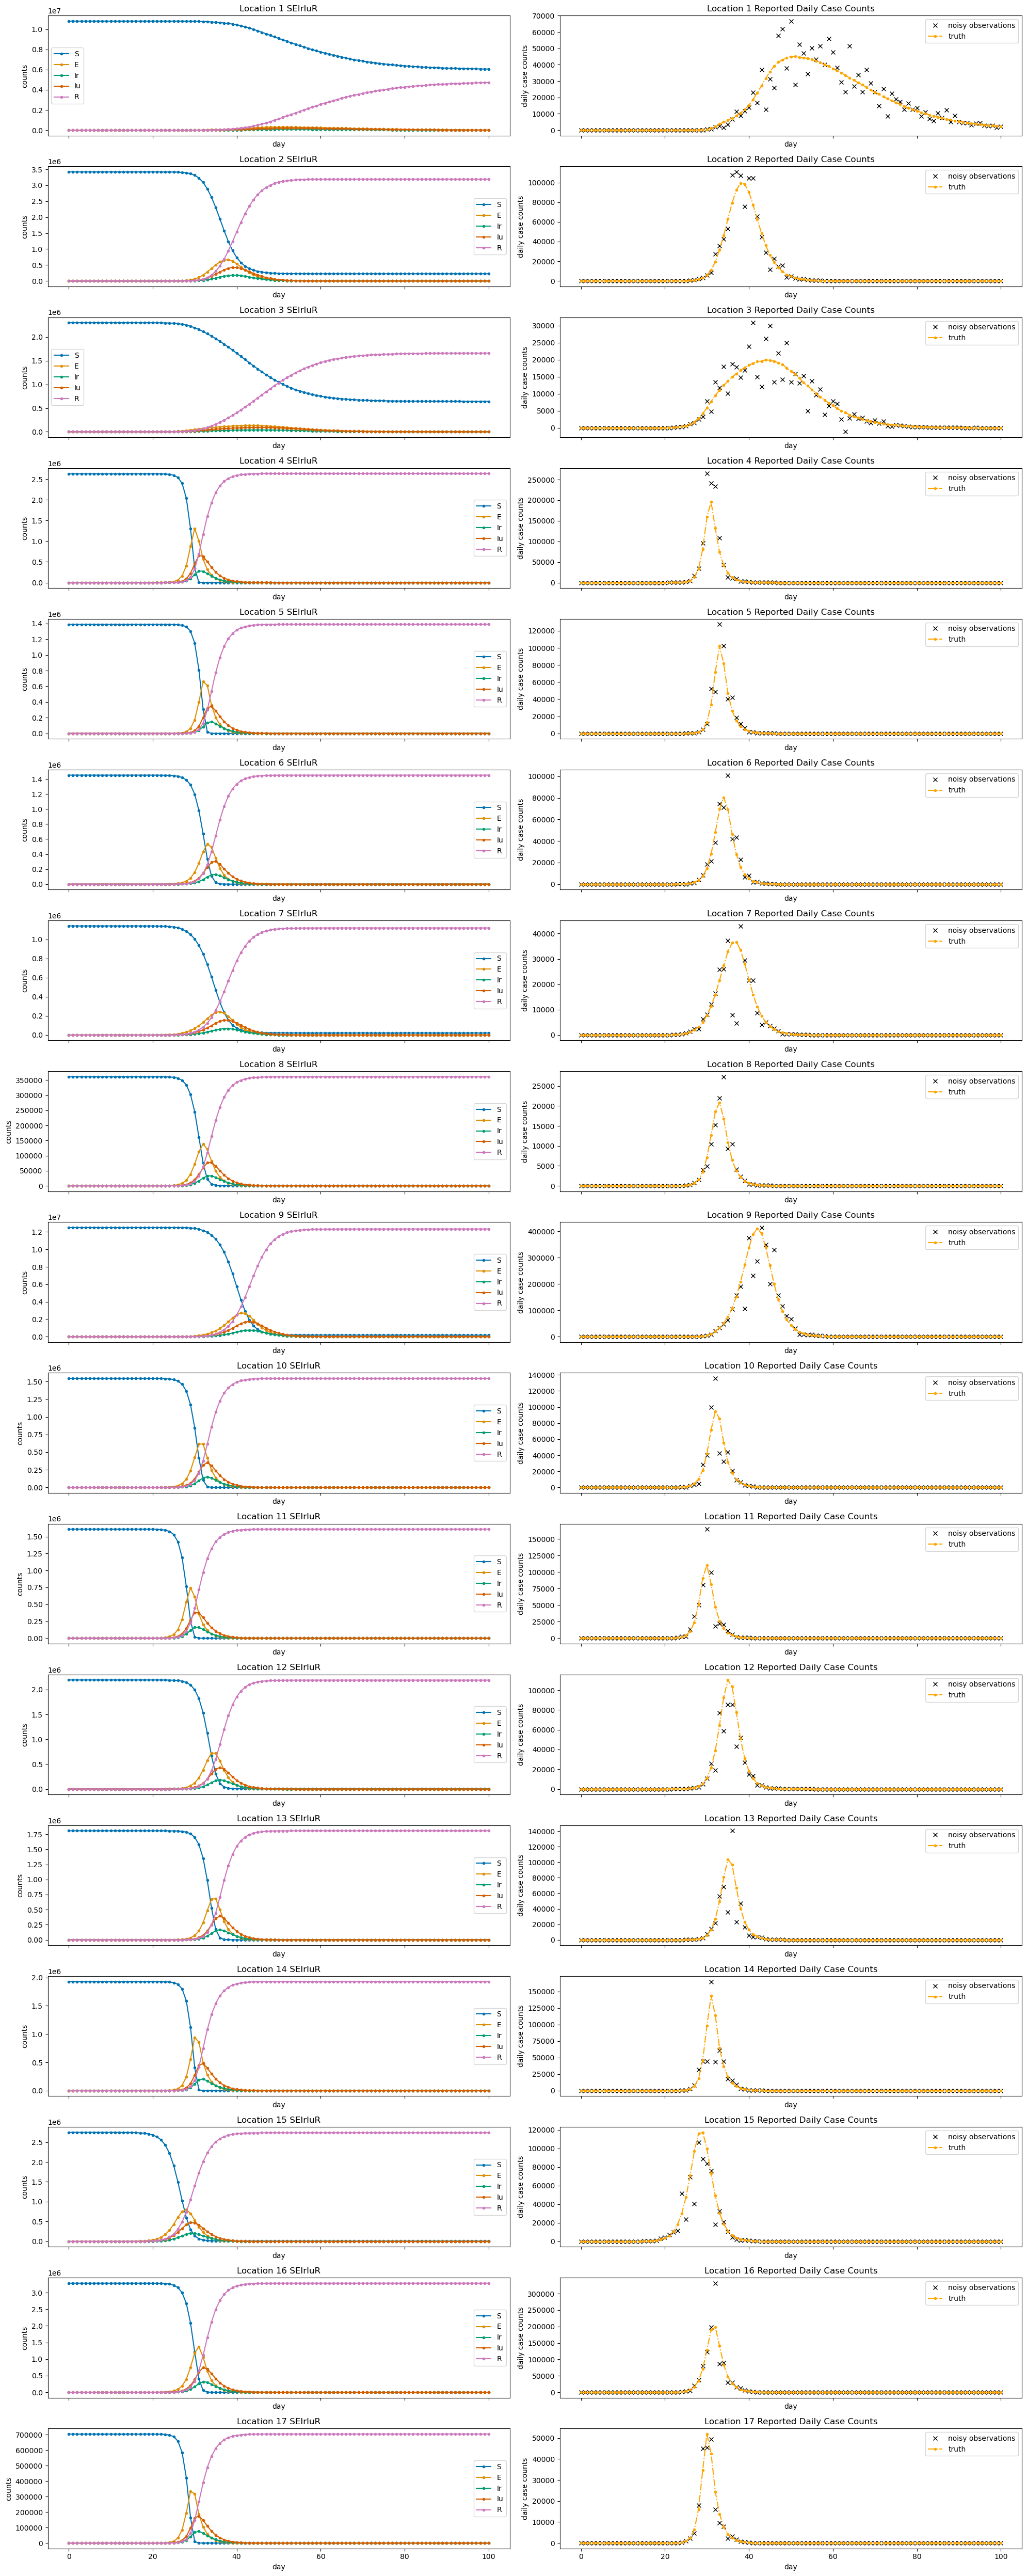

In [61]:
import seir_metapop
import importlib
importlib.reload(seir_metapop)

N = np.loadtxt("N.csv", delimiter=",", dtype=str).astype(np.float64)

true_params = {
    'beta': None,
    'mu': 0.5,
    'Z': 4,
    'D': 4,
    'alpha': 0.3,
    'n_t': 100,
    'n_loc': 17,
    'N': N,
    'E0': 0.,
    'Iu0': 10.,
}

np.random.seed(1994)
data = seir_metapop.simualte_data(**true_params, add_noise=True, noise_param=1/10)
data.plot_all()

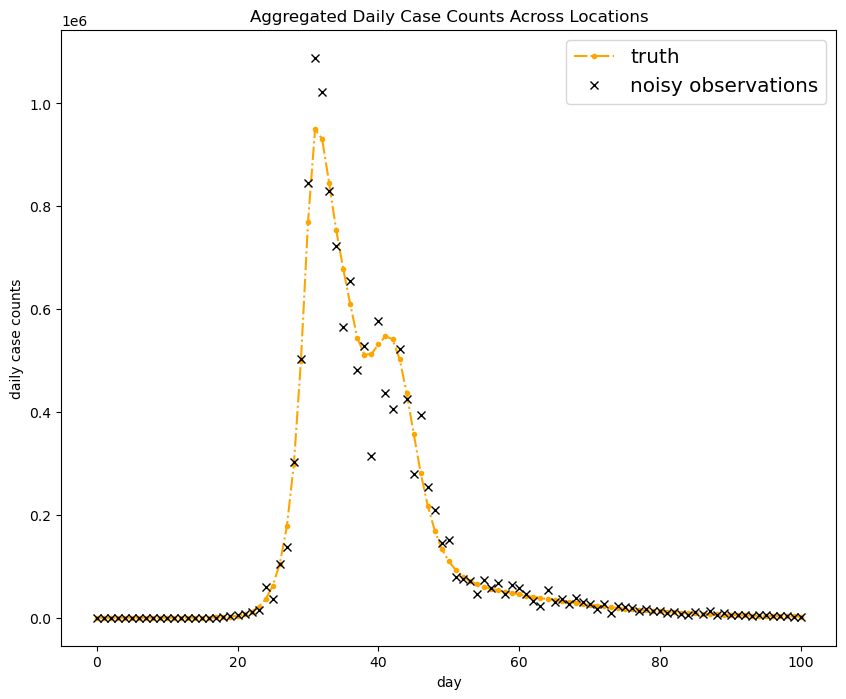

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
obs = np.sum(data.i, axis=1)
truth = np.sum(data.i_true, axis=1)
ax.plot(truth, '.-.', color='orange', label='truth')
ax.plot(obs, 'x', color='black', label='noisy observations')
ax.set_xlabel("day")
ax.set_ylabel("daily case counts")
ax.set_title("Aggregated Daily Case Counts Across Locations")
ax.legend(fontsize="x-large")

# Particle Filter

In [11]:
import math
import random
import numpy as np
from numpy.random import poisson
import matplotlib.pyplot as plt

true_params = {
    'beta': None,
    'mu': 0.5,
    'Z': 4,
    'D': 4,
    'alpha': 0.3,
    'n_t': 100,
    'n_loc': 17,
    'N': N,
    'E0': 0.,
    'Iu0': 10.,
}

moderlers_N = np.sum(N)
moderler_beta = np.average(data.beta, axis=1)


def forecast(t, x, dt=1):
    """
    forecast step
    """
    S = x[0]
    E = x[1]
    Ir = x[2]
    Iu = x[3]
    R = x[4]
    # Stochastic transitions
    dSE = poisson(moderler_beta[t]*S*(Ir+true_params['mu']*Iu)/moderlers_N)
    dEI = poisson(E/true_params['Z'])
    dIrR = poisson(Ir/true_params['D'])
    dIuR = poisson(Iu/true_params['D'])

    S_new = np.clip(S-dSE, 0, moderlers_N)
    E_new = np.clip(E+dSE-dEI, 0, moderlers_N)
    Ir_new = np.clip(Ir+dEI*true_params['alpha']-dIrR, 0, moderlers_N)
    Iu_new = np.clip(Iu+dEI*(1-true_params['alpha'])-dIuR, 0, moderlers_N)
    R_new = np.clip(R+dIrR+dIuR, 0, moderlers_N)
    i_new = np.clip(dEI*true_params['alpha'], 0, moderlers_N)

    # i_new = np.clip(dEI*true_params['alpha'] + np.random.normal(0,dEI*true_params['alpha']**2, 300), 0, moderlers_N)

    x_new = np.row_stack((S_new, E_new, Ir_new, Iu_new, R_new, i_new))
    return x_new


def f0(N, m=300):
    """
    Initial guess of the state space.
        Args:
            N: population
            m: number of ensemble members
    """
    S0 = np.random.uniform(N*0.99999, N, size=m)
    E0 = np.zeros(m)
    Ir0 = np.zeros(m)
    Iu0 = N - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)

    x = np.row_stack((S0, E0, Ir0, Iu0, R0, i0))
    return x


def resample(w, I):
    w_hat = [0]*300
    N = len(w)
    w_hat[0]=w[0]
    for j in range(1, N):
        w_hat[j] = sum(w[0:j+1])
    u = random.uniform(0, 1/N)
    k = 0
    for j in range(N):
        while u > w_hat[k]:
            k = k+1
            if k == len(w_hat):
                k=k-1
                break
        I[j] = k
        u = u+1/N
        k = 0
    return w, I
# C: random measurement noise
# H(z): model function provided by modeler


def oev(x):
    return np.maximum(1, x[-1]**2*(1/50))


def H(x):
    """
    Observational function.
        Args:
            x: state space
    """
    return x[-1]


def likelihood(d, z_j):
    C = oev(z_j)
    # if np.shape(C):
    #     detC = np.linalg.det(C)
    #     invC = np.linalg.inv(C)
    #     a = np.dot((d-H(z_j)), invC)
    #     a = np.dot(a, (d-H(z_j)))
    # else:
    detC = C
    invC = 1/C
    a = (d-H(z_j))*invC
    a = np.dot(a, (d-H(z_j)))

    b = 2*math.pi*detC
    a = (-1/2)*a/math.sqrt(b)

    return math.exp(a*2)


def basic_p_filter(z, d, t):
    # z is the list of all points, nxN
    # d is the measurement vector, m
    N = len(z[0])
    w = np.zeros(N)
    del_w = np.zeros(N)
    for j in range(N):
        try:
            del_w[j] = math.log(likelihood(d, z[:, j]))
        except:
            del_w[j] = 1e-7
    del_w_max = max(del_w)
    for j in range(N):
        del_w[j] = math.exp(del_w[j]-del_w_max)
    sum_w = sum(del_w)
    for j in range(N):
        w[j] = del_w[j]/sum_w
    if t > 20:
        I = np.zeros(N)
        w, I = resample(w, I)
        new_z = z.copy()
        I = I.astype('int')
        for j in range(N):
            new_z[:, j] = z[:, I[j]]
        return w, new_z
    else:
        return w, z

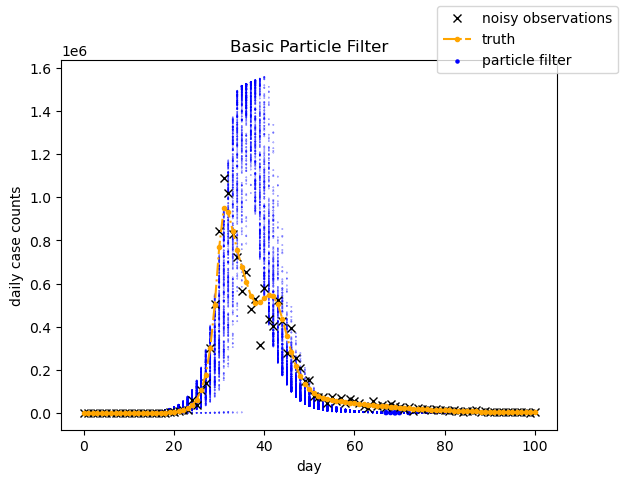

In [12]:
# initial ensemble
x = f0(moderlers_N)
x_list = [x]
x_forecast_list = [x]
w_list = []
for t in range(100):
    x = forecast(t, x)
    x_forecast_list.append(x)
    w, x = basic_p_filter(x, obs[t+1], t)
    w_list.append(w)
    x_list.append(x)

x_ens = np.array(x_list)

fig, ax = plt.subplots()

# ax.plot(np.array(x_forecast_list)[1:,-1,:], '-.', color = 'green')
true = np.sum(data.i_true, axis=1)
ax.plot(obs, 'x', color = 'black', label='noisy observations')
ax.plot(true, '.-.', color = 'orange', label='truth')
ax.scatter(np.arange(100), x_ens[1:,-1,0], color='blue', s=np.array(w_list)[:,0]*10, label="particle filter")
for i in range(1, 300):
    ax.scatter(np.arange(100), x_ens[1:,-1,i], s = np.array(w_list)[:,i]*10, color='blue')
ax.set_xlabel("day")
ax.set_ylabel("daily case counts")
ax.set_title(f"Basic Particle Filter")
fig.legend()

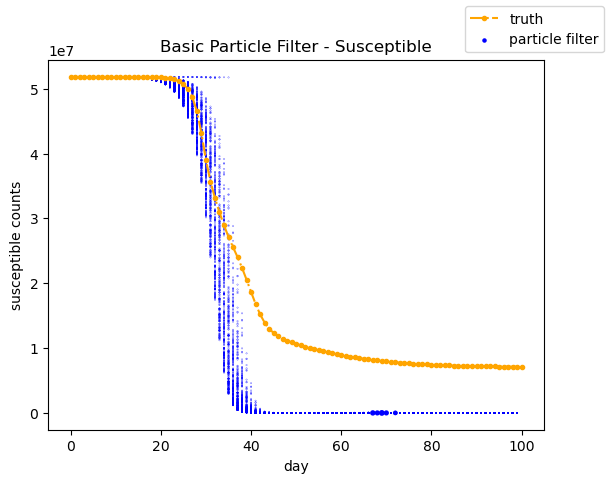

In [41]:
fig, ax = plt.subplots()

ax.plot(np.sum(data.S, axis=1), '.-.', color = 'orange', label='truth')
ax.scatter(np.arange(100), x_ens[1:,0,0], color='blue', s=np.array(w_list)[:,0]*10, label="particle filter")
for i in range(1, 300):
    ax.scatter(np.arange(100), x_ens[1:,0,i], s = np.array(w_list)[:,i]*10, color='blue')
ax.set_xlabel("day")
ax.set_ylabel("susceptible counts")
ax.set_title(f"Basic Particle Filter - Susceptible")
fig.legend()

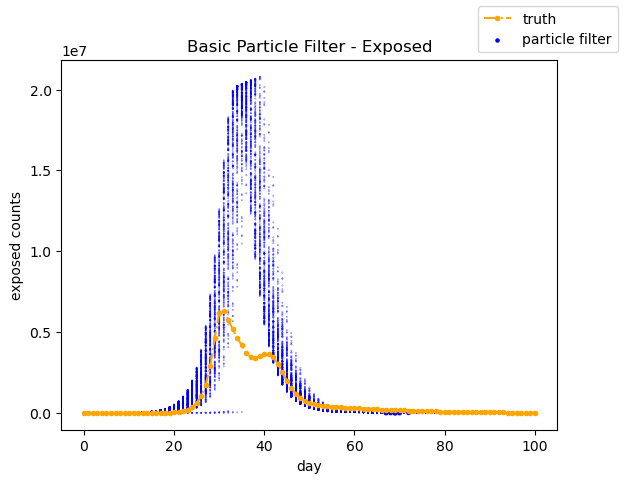

In [65]:
fig, ax = plt.subplots()

ax.plot(np.sum(data.E, axis=1), '.-.', color = 'orange', label='truth')
ax.scatter(np.arange(100), x_ens[1:,1,0], color='blue', s=np.array(w_list)[:,0]*10, label="particle filter")
for i in range(1, 300):
    ax.scatter(np.arange(100), x_ens[1:,1,i], s = np.array(w_list)[:,i]*10, color='blue')
ax.set_xlabel("day")
ax.set_ylabel("exposed counts")
ax.set_title(f"Basic Particle Filter - Exposed")
fig.legend()

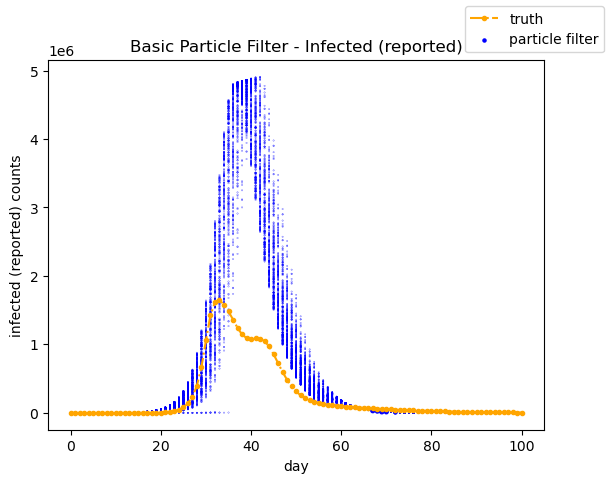

In [75]:
fig, ax = plt.subplots()

ax.plot(np.sum(data.Ir, axis=1), '.-.', color = 'orange', label='truth')
ax.scatter(np.arange(100), x_ens[1:,2,0], color='blue', s=np.array(w_list)[:,0]*10, label="particle filter")
for i in range(1, 300):
    ax.scatter(np.arange(100), x_ens[1:,2,i], s = np.array(w_list)[:,i]*10, color='blue')
ax.set_xlabel("day")
ax.set_ylabel("infected (reported) counts")
ax.set_title(f"Basic Particle Filter - Infected (reported)")
fig.legend()

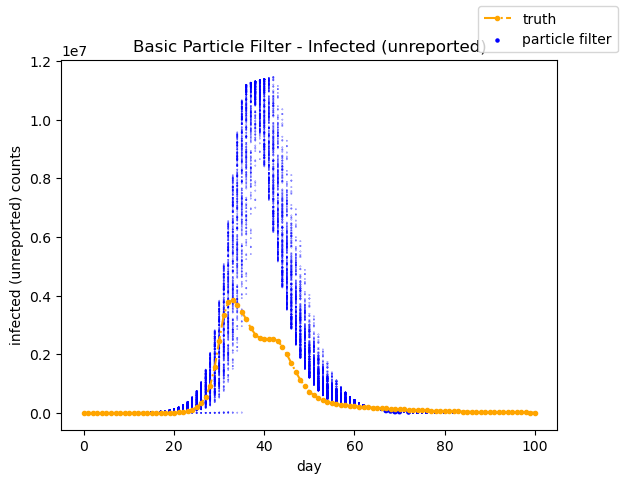

In [74]:
fig, ax = plt.subplots()

ax.plot(np.sum(data.Iu, axis=1), '.-.', color = 'orange', label='truth')
ax.scatter(np.arange(100), x_ens[1:,3,0], color='blue', s=np.array(w_list)[:,0]*10, label="particle filter")
for i in range(1, 300):
    ax.scatter(np.arange(100), x_ens[1:,3,i], s = np.array(w_list)[:,i]*10, color='blue')
ax.set_xlabel("day")
ax.set_ylabel("infected (unreported) counts")
ax.set_title(f"Basic Particle Filter - Infected (unreported)")
fig.legend()

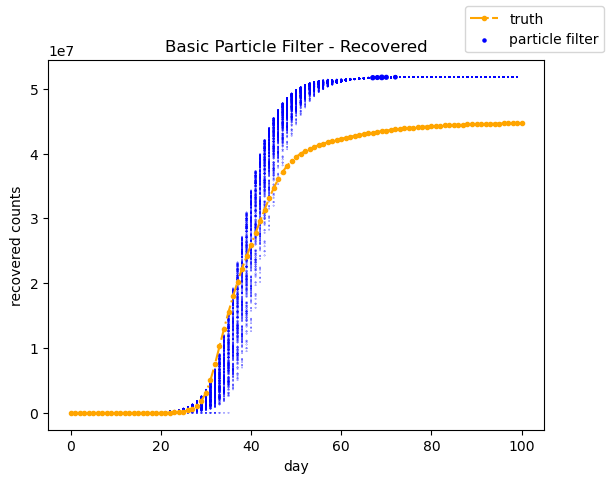

In [72]:
fig, ax = plt.subplots()

ax.plot(np.sum(data.R, axis=1), '.-.', color = 'orange', label='truth')
ax.scatter(np.arange(100), x_ens[1:,4,0], color='blue', s=np.array(w_list)[:,0]*10, label="particle filter")
for i in range(1, 300):
    ax.scatter(np.arange(100), x_ens[1:,4,i], s = np.array(w_list)[:,i]*10, color='blue')
ax.set_xlabel("day")
ax.set_ylabel("recovered counts")
ax.set_title(f"Basic Particle Filter - Recovered")
fig.legend()

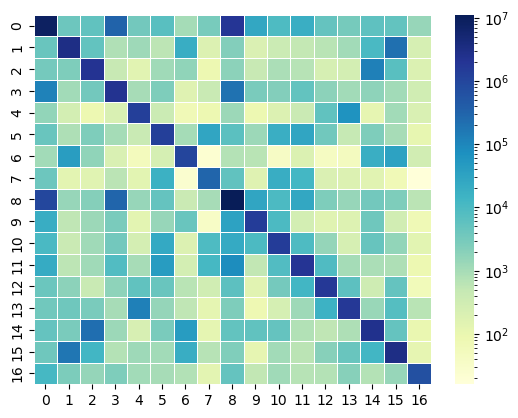

In [28]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

sns.set_palette("colorblind")
ax = sns.heatmap(N, linewidth=0.5, cmap="YlGnBu", norm=LogNorm())
plt.show()

# Archive

In [ ]:
#  def f(t, x, θ, N, dt=1, noise_param=1/25):
#     """
#     forecast step
#     S = x[0]
#     E = x[1]
#     Ir = x[2]
#     Iu = x[3]
#     R = x[4]
#     """

#     # Stochastic transitions
#     dSE = np.random.poisson(true_params["beta"]*S[t]*(Ir[t]+self.mu*Iu[t])/self.N)
#     dEI = np.random.poisson(E[t]/self.Z)
#     dIrR = np.random.poisson(Ir[t]/self.D)
#     dIuR = np.random.poisson(Iu[t]/self.D)

#     S_new = np.clip(S[t]-dSE, 0, self.N)
#     E_new = np.clip(E[t]+dSE-dEI, 0, self.N)
#     Ir_new = np.clip(Ir[t]+dEI*self.alpha-dIrR, 0, self.N)
#     Iu_new = np.clip(Iu[t]+dEI*(1-self.alpha)-dIuR, 0, self.N)
#     R_new = np.clip(R[t]+dIrR+dIuR, 0, self.N)
    
#     x_new = np.concatenate((S_new, E_new, Ir_new, Iu_new, R_new, dEI*self.alpha))

#     return x_new

# def h(x):
#     """
#     Observational function.
#         Args:
#             x: state space
#     """
#     return x[-1]

# def f0(N, m=300):
#     """
#     Initial guess of the state space.
#         Args:
#             N: population
#             m: number of ensemble members
#     """

#     S0 = np.random.uniform(N*0.8, pop, size=m)
#     E0 = np.zeros(m)
#     Ir0 = np.zeros(m)
#     Iu0 = N - S0
#     R0 = np.zeros(m)
#     i0 = np.zeros(m)
    
#     x = np.concatenate((S0, E0, Ir0, Iu0, R0, i0))
#     return x

# def c(x, noise_param=1/50):
#     return np.maximum(1., x[-1]**2 * noise_param)